In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from skimage.measure import  compare_ssim
from collections import Counter
import glob

import warnings
warnings.simplefilter("ignore")

In [2]:
#List all image files

image_list = []
Test_path ='Datos/Test/*'
Category = []

artist = 0
for root1 in glob.glob(Test_path):
    base2=root1+'/*.jpg'
    for (root3) in glob.glob(base2):
        image_list.append(root3)
        Category.append(artist)        
    artist+=1
    
# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),224,224))
data_set_vec=np.zeros((224*224,len(image_list)))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(224, 224)),cv2.COLOR_BGR2GRAY)
    data_set_vec[:,image]=np.reshape(data_set[image,:,:], (-1))
    
Test_Data = data_set_vec.T
Category_Test = Category

In [3]:
image_list = []
Train_path ='Datos/Train/*'
Category = []

artist = 0
for root1 in glob.glob(Train_path):
    base2=root1+'/*.jpg'
    for (root3) in glob.glob(base2):
        image_list.append(root3)
        Category.append(artist)        
    artist+=1
    
# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),224,224))
data_set_vec=np.zeros((224*224,len(image_list)))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(224, 224)),cv2.COLOR_BGR2GRAY)
    data_set_vec[:,image]=np.reshape(data_set[image,:,:], (-1))
    
Train_Data = data_set_vec.T
Category_Train = Category

In [4]:
image_list = []
Validation_path ='Datos/Validation/*'
Category = []

artist = 0
for root1 in glob.glob(Validation_path):
    base2=root1+'/*.jpg'
    for (root3) in glob.glob(base2):
        image_list.append(root3)
        Category.append(artist)        
    artist+=1
    
# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),224,224))
data_set_vec=np.zeros((224*224,len(image_list)))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(224, 224)),cv2.COLOR_BGR2GRAY)
    data_set_vec[:,image]=np.reshape(data_set[image,:,:], (-1))
    
Validation_Data = data_set_vec.T
Category_Val = Category

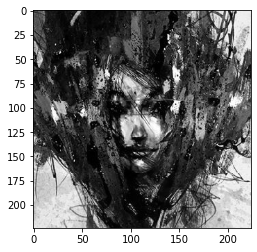

In [5]:
plt.imshow(np.reshape(data_set_vec[:,0],(224,224)), cmap = plt.cm.gray)

In [6]:
Input = np.concatenate((Train_Data, Test_Data))
Output = np.array(Category_Train + Category_Test)

In [7]:
param_grid = {'C': [1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [0.001, 0.0001]}
svm = SVC()

In [8]:
cls = GridSearchCV(svm, param_grid, )
cls.fit(X = Input, y = Output)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [9]:
Classifier = cls.best_estimator_

kf = KFold(n_splits=10)

f1_list = []
acc_list = []

for train_index, test_index in kf.split(Input):
    Xtr, Xts = Input[train_index,:], Input[test_index,:]
    Ytr, Yts = Output[train_index], Output[test_index]
    
    Classifier.fit(Xtr, Ytr)
    
    y_pred = Classifier.predict(Xts)
    
    f1_list.append(f1_score(Yts, y_pred, average = 'weighted'))
    acc_list.append(accuracy_score(Yts, y_pred))

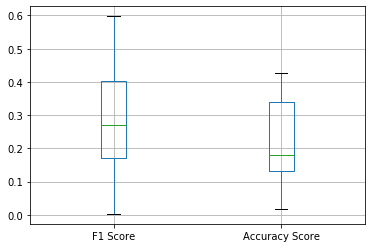

In [10]:
Stability = pd.DataFrame()
Stability['F1 Score'] = f1_list
Stability['Accuracy Score'] = acc_list
Stability.boxplot()

In [11]:
y_pred = Classifier.predict(Validation_Data)

print('El F1 score es: {}'.format(f1_score(Category_Val, y_pred, average = 'weighted')))
print('El Accuracy score es: {}'.format(accuracy_score(Category_Val, y_pred)))

El F1 score es: 0.3150602964190371
El Accuracy score es: 0.36619718309859156


#### Revisión del accuracy con los datos estandarizados. 

In [12]:
Scaler = StandardScaler()
Input_scaled = Scaler.fit_transform(Input)

svm = SVC()

In [13]:
cls = GridSearchCV(svm, param_grid)
cls.fit(X = Input_scaled, y = Output)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
Classifier = cls.best_estimator_

kf = KFold(n_splits=10)

f1_list = []
acc_list = []

for train_index, test_index in kf.split(Input_scaled):
    Xtr, Xts = Input_scaled[train_index,:], Input_scaled[test_index,:]
    Ytr, Yts = Output[train_index], Output[test_index]
    
    Classifier.fit(Xtr, Ytr)
    
    y_pred = Classifier.predict(Xts)
    
    f1_list.append(f1_score(Yts, y_pred, average = 'weighted'))
    acc_list.append(accuracy_score(Yts, y_pred))

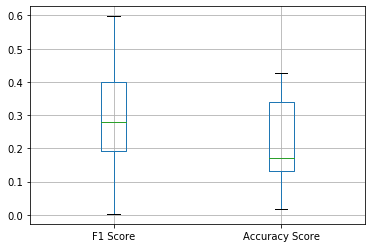

In [15]:
Stability = pd.DataFrame()
Stability['F1 Score'] = f1_list
Stability['Accuracy Score'] = acc_list
Stability.boxplot()

In [16]:
X_test_scaled = Scaler.transform(Validation_Data)
y_pred = Classifier.predict(X_test_scaled)

print('El F1 score es: {}'.format(f1_score(Category_Val, y_pred, average = 'weighted')))
print('El Accuracy score es: {}'.format(accuracy_score(Category_Val, y_pred)))

El F1 score es: 0.3154242371694829
El Accuracy score es: 0.36619718309859156
